# Run Boostvqe in Quantinuum

Following our example in the notebook `gci_boostvqe_circuit_synthesis.ipynb`, we will load the VQE and GCI circuits and run on Quantinuum Nexus emulators.

## Load VQE and GCI circuits

In [82]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
from quantinuum_utils import *

In [ ]:
import os
os.chdir('..')
optimizer = 'sgd'
nqubits = 4
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
gci_circ_file = folder_path + 'gci_circ.qasm'

In [ ]:
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
# render_circuit_jupyter(vqe_circ)

In [ ]:
gci_circ = pytket.qasm.circuit_from_qasm(gci_circ_file)
# render_circuit_jupyter(gci_circ)

# Quantinuum preparation

Let us check the size of the GCI circuit.

In [ ]:
print("Circuit depth:", gci_circ.depth())
print("Circuit total gate count:", gci_circ.n_gates)
num_cnots = sum(1 for command in gci_circ if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

In [ ]:
import qnexus as qnx

In [ ]:
# connect to nexus account
qnx.client.auth.login()

In [ ]:
# connect to nexus project
project_name = "boostvqe_demo_XXZ"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

### Hamiltonian in Pytket

In [ ]:
# XXZ model
nqubits = 4
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

### Measurement setup
Based on the hamiltonian in Pauli basis, we create a list of measurement setup for evaluating each non-commuting set of Pauli components of the hamiltonian.

In [ ]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
# for mc in measurement_setup.measurement_circs:
#     render_circuit_jupyter(mc)

Here, we have created measurement circuits for the $X$, $Y$, and $Z$ terms. Next, we can upload and compile the measurement circuits.

## Compile circuits

We are now running noiseless emulation.

In [ ]:
optimisation_level = 1

In [56]:
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    c = gci_circ.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

# compile vqe measurement circuit list
compiled_vqe_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=vqe_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_gci_circuit_refs = qnx.compile(
            name=f"compile_job_GCI_{datetime.now()}",
            circuits=gci_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

## Optimisation level test

In [80]:
from pytket.circuit import OpType
from datetime import datetime

# Define your optimization levels
optimization_levels = [0,1,2]

# Dictionary to store compiled circuits per optimization level
vqe_compiled_circuits_dict = {}
gci_compiled_circuits_dict = {}

# Compile circuits for each optimization level
for opt_level in optimization_levels:
    vqe_compile_job = qnx.compile(
        name=f"compile_job_VQE_opt_{opt_level}_{datetime.now()}",
        circuits=vqe_circuit_ref_list,
        optimisation_level=opt_level,
        backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
        timeout=None,
    )
    vqe_compiled_circuits_dict[opt_level] = vqe_compile_job
    gci_compile_job = qnx.compile(
        name=f"compile_job_GCI_opt_{opt_level}_{datetime.now()}",
        circuits=gci_circuit_ref_list,
        optimisation_level=opt_level,
        backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
        timeout=None,
    )
    gci_compiled_circuits_dict[opt_level] = gci_compile_job

In [106]:
# Function to retrieve and analyze compiled circuits from a compile job
def retrieve_and_analyze_compiled_circuits(compile_jobs, opt_level):
    """Waits for jobs to complete, downloads results, and analyzes gate counts."""
    job = compile_jobs[0]
    # Download the compiled circuit
    compiled_circuit = job.download_circuit()
    
    # Analyze gate counts
    circuit_depth = compiled_circuit.depth()
    total_gates = compiled_circuit.n_gates
    # for command in compiled_circuit:
    #     print(command.op.type)
    # num_cnots = sum(1 for command in compiled_circuit if command.op.type == OpType.CZ)
    # print(num_cnots)
    
    # Print the analysis
    print(f"--- Optimization Level: {opt_level} ---")
    print(f"Circuit Depth: {circuit_depth}")
    print(f"Total Gate Count: {total_gates}")
    # print(f"CNOT Gate Count: {num_cnots}\n")
    
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


def plot_grouped_op_type_frequencies(circuits, labels, figsize=(14, 8)):
    """
    Generates a grouped bar plot of operation type frequencies for multiple pytket circuits,
    with frequency values displayed on top of each bar.

    Parameters:
    - circuits (list of pytket.circuit.Circuit): List of pytket circuits to analyze.
    - labels (list of str): Labels for each circuit (e.g., optimization levels).
    - figsize (tuple, optional): Size of the figure. Default is (14, 8).

    Returns:
    - None: Displays the plot.
    """

    if len(circuits) != len(labels):
        raise ValueError("The number of circuits must match the number of labels.")

    # Step 1: Aggregate all unique OpTypes across all circuits
    all_op_types = set()
    for circuit in circuits:
        all_op_types.update([command.op.type for command in circuit])
    all_op_types = sorted(all_op_types, key=lambda x: x.name)  # Sort alphabetically by name

    # Step 2: Count frequencies for each circuit
    freq_dicts = []
    for circuit in circuits:
        op_types = [command.op.type for command in circuit]
        op_counts = Counter(op_types)
        # Ensure all OpTypes are present, even if count is zero
        freq = {op_type.name: op_counts.get(op_type, 0) for op_type in all_op_types}
        freq_dicts.append(freq)

    # Step 3: Prepare data for plotting
    op_labels = [op_type.name for op_type in all_op_types]
    num_op_types = len(op_labels)
    num_circuits = len(circuits)

    # Set the positions and width for the bars
    bar_width = 0.8 / num_circuits  # Total width is 0.8, divided among circuits
    indices = np.arange(num_op_types)

    # Step 4: Create the plot
    plt.figure(figsize=figsize)

    # Set default colors if none provided
    colors = plt.cm.tab10.colors  # Default matplotlib color cycle

    # Ensure there are enough colors
    if len(colors) < len(circuits):
        # Repeat colors if not enough
        colors = colors * (len(circuits) // len(colors) + 1)

    for i, freq in enumerate(freq_dicts):
        counts = [freq[op] for op in op_labels]
        # Calculate position for each circuit's bars
        bar_positions = indices - 0.4 + (i + 0.5) * bar_width
        bars = plt.bar(bar_positions, counts, width=bar_width, label=labels[i], color=colors[i])

        # Add frequency labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.annotate('{}'.format(height),
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=9)

    # Step 5: Customize the plot
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Frequency of Operation Types Across Circuits', fontsize=16)
    plt.xticks(indices, op_labels, rotation=45, ha='right')
    plt.legend(title='Circuits', fontsize=12, title_fontsize=12)
    plt.tight_layout()

    # Optional: Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Step 6: Display the plot
    plt.show()

In [99]:
# Iterate over each optimization level and process the compile jobs
circuits = []
for opt_level, compile_jobs in gci_compiled_circuits_dict.items():
    print(f"\nProcessing Optimization Level: {opt_level}")
    retrieve_and_analyze_compiled_circuits(compile_jobs, opt_level)
    job = compile_jobs[0]
    # Download the compiled circuit
    compiled_circuit = job.download_circuit()
    circuits.append(compiled_circuit)


Processing Optimization Level: 0
--- Optimization Level: 0 ---
Circuit Depth: 498
Total Gate Count: 1662

Processing Optimization Level: 1
--- Optimization Level: 1 ---
Circuit Depth: 184
Total Gate Count: 546

Processing Optimization Level: 2
--- Optimization Level: 2 ---
Circuit Depth: 144
Total Gate Count: 434


In [109]:
circuits.append(gci_circ)

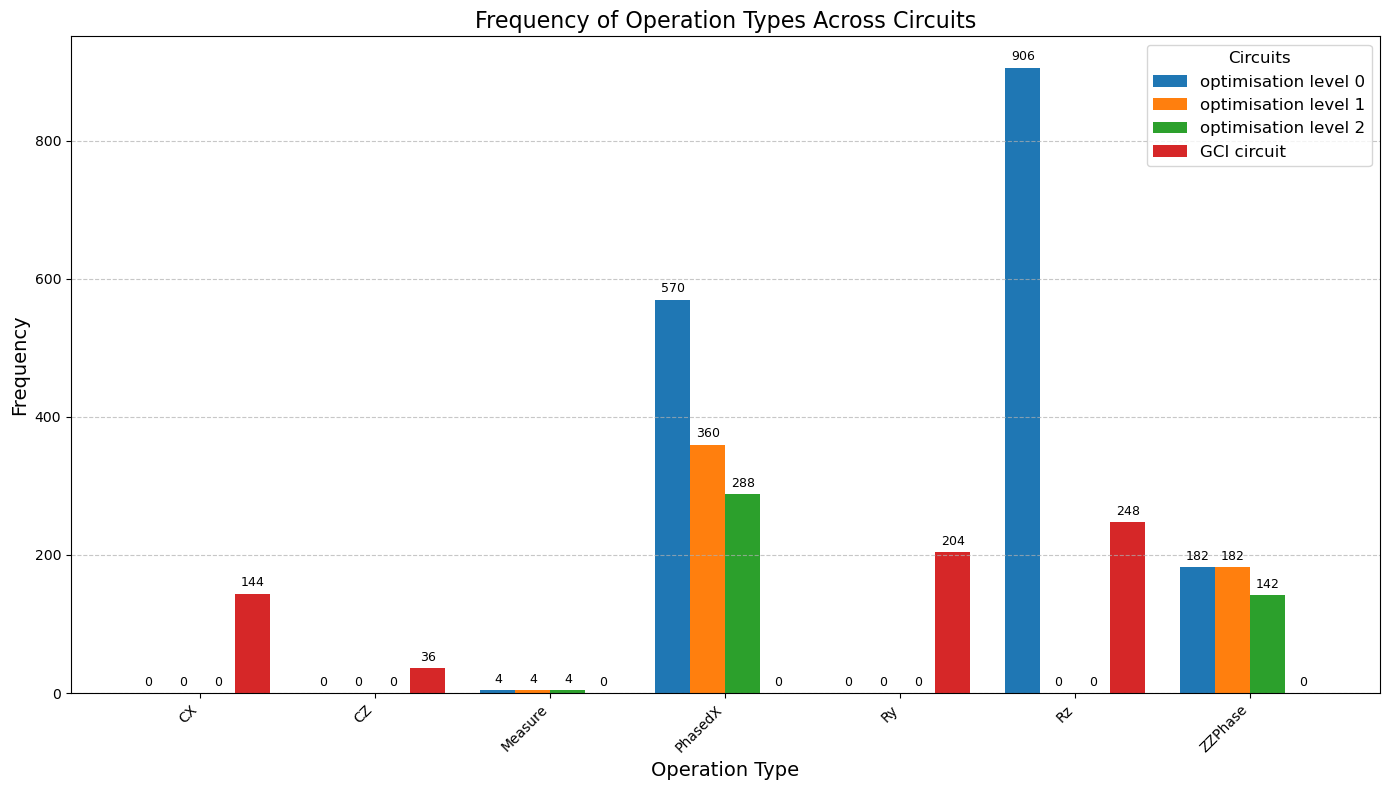

In [110]:
plot_grouped_op_type_frequencies(circuits, labels=[f'optimisation level {optimisation_level}' for optimisation_level in range(3)]+['GCI circuit'])

# Run without noise

In [ ]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE") 

In [ ]:
vqe_job_name = f"execute_job_VQE_{nshots}shots_{datetime.now()}"
gci_job_name = f"execute_job_GCI_{nshots}shots_{datetime.now()}"
results_vqe = qnx.start_execute_job(
            name=vqe_job_name,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci = qnx.start_execute_job(
            name=gci_job_name,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [ ]:
from pathlib import Path
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_ol{optimisation_level}_XXZ/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe,
    path=Path.cwd() / folder_path / vqe_job_name,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci,
    path=Path.cwd() /folder_path / gci_job_name,
    mkdir=True,
)

# Retrieve noiseless results

Without running repeated jobs, we can retrieve our results from the Qnexus project.

In [ ]:
import qnexus as qnx
from pathlib import Path

In [ ]:
optimisation_level = 1
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ/'
vqe_job_file = folder_path + 'execute_job_VQE_2000shots_2024-11-06 16:01:11.142908'
gci_job_file = folder_path + 'execute_job_GCI_2000shots_2024-11-06 16:01:11.143008'

In [ ]:
vqe_job_ref = qnx.filesystem.load(
    path=Path.cwd() / vqe_job_file
)

gci_job_ref = qnx.filesystem.load(
    path=Path.cwd() / gci_job_file
)

In [ ]:
print(qnx.jobs.status(vqe_job_ref))
print(qnx.jobs.status(gci_job_ref))

In [ ]:
vqe_results = [job.download_result() for job in qnx.jobs.results(vqe_job_ref)]
gci_results = [job.download_result() for job in qnx.jobs.results(gci_job_ref)]

In [ ]:
# XXZ model
nqubits = 4
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)

In [ ]:
expval_vqe = compute_expectation_value_from_results(
    vqe_results, measurement_setup, ham_quantinuum
)
print(expval_vqe)

In [ ]:
expval_gci = compute_expectation_value_from_results(
    gci_results, measurement_setup, ham_quantinuum
)
print(expval_gci)

# With noise

In [ ]:
backend_config = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)
nshots = 2000

In [ ]:
vqe_job_name_with_noise = f"execute_job_VQE_{nshots}shots_noise_{datetime.now()}"
gci_job_name_with_noise = f"execute_job_GCI_{nshots}shots_noise_{datetime.now()}"
results_vqe_noise = qnx.start_execute_job(
            name=vqe_job_name_with_noise,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci_noise = qnx.start_execute_job(
            name=gci_job_name_with_noise,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [ ]:
from pathlib import Path
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe_noise,
    path=Path.cwd() / folder_path / vqe_job_name_with_noise,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci_noise,
    path=Path.cwd() / folder_path / gci_job_name_with_noise,
    mkdir=True,
)

# Retrieve noisy results

In [ ]:
gci_job_file_noise = 'results/qnx_job_ref/sgd_4q_1l_1ol_XXZ/execute_job_GCI_2000shots_noise_2024-11-18 20:23:34.273262'
vqe_job_file_noise = 'results/qnx_job_ref/sgd_4q_1l_1ol_XXZ/execute_job_VQE_2000shots_noise_2024-11-18 20:23:34.273095'

In [ ]:
vqe_job_ref_noise = qnx.filesystem.load(
    path=Path.cwd() / vqe_job_file_noise
)

gci_job_ref_noise = qnx.filesystem.load(
    path=Path.cwd() / gci_job_file_noise
)

In [ ]:
print(qnx.jobs.status(vqe_job_ref_noise))
print(qnx.jobs.status(gci_job_ref_noise))

In [ ]:
vqe_results_noise = [job.download_result() for job in qnx.jobs.results(vqe_job_ref_noise)]
gci_results_noise = [job.download_result() for job in qnx.jobs.results(gci_job_ref_noise)]

In [ ]:
expval_vqe_noise = compute_expectation_value_from_results(
    vqe_results_noise, measurement_setup, ham_quantinuum
)
print(expval_vqe_noise)

In [ ]:
expval_gci_noise = compute_expectation_value_from_results(
    gci_results_noise, measurement_setup, ham_quantinuum
)
print(expval_gci_noise)

# Prepare report

In [ ]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
qibo.set_backend("numpy")

In [ ]:
nqubits = 4
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

In [ ]:
with open (vqe_circ_file, "r") as file:
    vqe_circuit_qasm_str = file.read()
    
with open (gci_circ_file, "r") as file:
    gci_circuit_qasm_str = file.read()

In [ ]:
vqe_circ_qibo = qibo.models.Circuit.from_qasm(vqe_circuit_qasm_str)
gci_circ_qibo = qibo.models.Circuit.from_qasm(gci_circuit_qasm_str)

In [ ]:
report_quantinuum = report(vqe_circ_qibo, gci_circ_qibo, ham, expval_vqe, expval_gci, expval_vqe_noise, expval_gci_noise)

In [ ]:
report_table(report_quantinuum)